## Mini-Project 3:  Computer Vision using GPU and Transfer Learning
#### CSC 180 Intelligent Systems<br>Dr. Haiquan Chen, California State University, Sacramento

## Jabari Crenshaw, 219953891
## John Kieren, 301144467
### CSC 180, Project 3<br>Due: 28 October 2022

## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [2]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 

## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
#  Load cifar-10 data and split it to training and test

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


In [4]:
# print out data shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


Image (#19321): Which is picture of [7]


'\ny_train[idx] == Label\ninfer corresponding Description\n\nLabel \tDescription\n0 \tairplane\n1 \tautomobile\n2 \tbird\n3 \tcat\n4 \tdeer\n5 \tdog\n6 \tfrog\n7 \thorse\n8 \tship\n9 \ttruck\n'

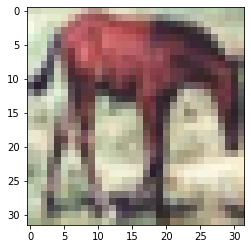

In [5]:
# print out a random image in x_train as numpy array ...
  # ... and print it out as image
import matplotlib.pyplot as plt

idx = np.random.randint(1,x_train.shape[0])
img = x_train[idx]
plt.imshow(img)

print(f'Image (#{idx}): Which is picture of {y_train[idx]}')

'''
y_train[idx] == Label
infer corresponding Description

Label 	Description
0 	airplane
1 	automobile
2 	bird
3 	cat
4 	deer
5 	dog
6 	frog
7 	horse
8 	ship
9 	truck
'''

In [6]:
# Convert y_train from 2D to 1D 
y_train = y_train.reshape(50000)
print('y_train shape:', y_train.shape)

# Convert y_test from 2D to 1D 
y_test = y_test.reshape(10000)
print('y_test shape: ', y_test.shape)

y_train shape: (50000,)
y_test shape:  (10000,)


In [7]:
# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Convert data from int to float and normalize it
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape,'\n',
      x_test.shape,'\n',
      y_train.shape,'\n',
      y_test.shape)

(50000, 32, 32, 3) 
 (10000, 32, 32, 3) 
 (50000, 10) 
 (10000, 10)


###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', padding='same',
                 input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


'''
#Conv2D
model.add( Conv2D(32, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu', input_shape=(32,32,3) ) )

#Conv2d
model.add( Conv2D(64, kernel_size=(3,3),activation='relu', padding='same') )

#MaxPooling2D
model.add(MaxPooling2D( pool_size=(2,2), strides=None ))

#Dropout
model.add( Dropout( 0.33 ) )

#Flatten
model.add( Flatten() )

#Dense
model.add( Dense(128, activation='relu') )

#Dense
model.add( Dense(num_classes, activation='relu') )
'''


"\n#Conv2D\nmodel.add( Conv2D(32, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu', input_shape=(32,32,3) ) )\n\n#Conv2d\nmodel.add( Conv2D(64, kernel_size=(3,3),activation='relu', padding='same') )\n\n#MaxPooling2D\nmodel.add(MaxPooling2D( pool_size=(2,2), strides=None ))\n\n#Dropout\nmodel.add( Dropout( 0.33 ) )\n\n#Flatten\nmodel.add( Flatten() )\n\n#Dense\nmodel.add( Dense(128, activation='relu') )\n\n#Dense\nmodel.add( Dense(num_classes, activation='relu') )\n"

In [10]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 1000)             

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

Test Model 1

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit( x_train[0:10000], y_train[0:10000],
          batch_size=128, epochs=256, verbose=2,
          validation_data=(x_test[0:3000], y_test[0:3000]) )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/256
79/79 - 12s - loss: 1.8367 - accuracy: 0.3288 - val_loss: 1.5365 - val_accuracy: 0.4497 - 12s/epoch - 157ms/step
Epoch 2/256
79/79 - 1s - loss: 1.4298 - accuracy: 0.4890 - val_loss: 1.4095 - val_accuracy: 0.4957 - 733ms/epoch - 9ms/step
Epoch 3/256
79/79 - 1s - loss: 1.2420 - accuracy: 0.5593 - val_loss: 1.4234 - val_accuracy: 0.5063 - 655ms/epoch - 8ms/step
Epoch 4/256
79/79 - 1s - loss: 1.0960 - accuracy: 0.6095 - val_loss: 1.2137 - val_accuracy: 0.5757 - 662ms/epoch - 8ms/step
Epoch 5/256
79/79 - 1s - loss: 0.9680 - accuracy: 0.6583 - val_loss: 1.2265 - val_accuracy: 0.5783 - 653ms/epoch - 8ms/step
Epoch 6/256
79/79 - 1s - loss: 0.8098 - accuracy: 0.7159 - val_loss: 1.2953 - val_accuracy: 0.5700 - 666ms/epoch - 8ms/step
Epoch 7/256
79/79 - 1s - loss: 0.6794 - accuracy: 0.7625 - val_loss: 1.3087 - val_accuracy: 0.5740 - 642ms/epoch - 8ms/step
Epoch 8/256
79/79 - 1s - loss: 0.5621 - accuracy: 0.8047 - val_loss: 1.2368 - val_accuracy: 0.5990 - 655ms/epoch - 8ms/step
Epoch 9

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_true = np.argmax(y_test[0:3000], axis=1)
prediction = model.predict(x_test[0:3000])
prediction = np.argmax(prediction, axis=1)

metrics = { 'Accuracy Score' : metrics.accuracy_score(y_true, prediction),
            'Averaged Precision Score' : metrics.precision_score(y_true, prediction, average='weighted'),
            'Averaged Recall Score' : metrics.recall_score(y_true, prediction, average='weighted'),
            'Averaged F1 Score' : metrics.f1_score(y_true, prediction, average='weighted')}
for k,v in metrics.items():
  print(f'{k} : {v}')

print(classification_report(y_true, prediction))
print( model.evaluate(x_test[0:3000], y_test[0:3000], verbose=0) )

94/94 [==============================] - 0s 2ms/step
Accuracy Score : 0.616
Averaged Precision Score : 0.6143961153939752
Averaged Recall Score : 0.616
Averaged F1 Score : 0.6144336583089134
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       299
           1       0.71      0.70      0.70       287
           2       0.52      0.50      0.51       318
           3       0.42      0.43      0.42       295
           4       0.54      0.55      0.55       299
           5       0.51      0.45      0.48       290
           6       0.69      0.76      0.72       307
           7       0.70      0.68      0.69       286
           8       0.68      0.77      0.72       316
           9       0.71      0.66      0.68       303

    accuracy                           0.62      3000
   macro avg       0.61      0.62      0.61      3000
weighted avg       0.61      0.62      0.61      3000

[5.790398597717285, 0.6159999966621399]


### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

In [ ]:
for i in range(0, 5):
  idx = np.random.randint(1,prediction.shape[0])
  print(f'Photograph #{idx}... Actual Classification: {y_true[idx]} -> Predicted Classification: {prediction[idx]}')
  


Photograph #1143... Actual Classification: 6 -> Predicted Classification: 6
Photograph #733... Actual Classification: 9 -> Predicted Classification: 9
Photograph #1575... Actual Classification: 2 -> Predicted Classification: 2
Photograph #1779... Actual Classification: 3 -> Predicted Classification: 5
Photograph #2367... Actual Classification: 4 -> Predicted Classification: 2
Photograph #2066... Actual Classification: 2 -> Predicted Classification: 2
Photograph #2836... Actual Classification: 3 -> Predicted Classification: 3
Photograph #492... Actual Classification: 8 -> Predicted Classification: 8
Photograph #1252... Actual Classification: 5 -> Predicted Classification: 3
Photograph #1302... Actual Classification: 6 -> Predicted Classification: 6
Photograph #658... Actual Classification: 4 -> Predicted Classification: 4
Photograph #125... Actual Classification: 0 -> Predicted Classification: 9
Photograph #1899... Actual Classification: 7 -> Predicted Classification: 7
Photograph #36..

Test Model 2

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.40))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                      

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit( x_train[0:19000], y_train[0:19000],
          batch_size=128, epochs=256, verbose=2,
          validation_data=(x_test[0:5000], y_test[0:5000]) )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/256
149/149 - 2s - loss: 1.8246 - accuracy: 0.3364 - val_loss: 1.4858 - val_accuracy: 0.4692 - 2s/epoch - 14ms/step
Epoch 2/256
149/149 - 1s - loss: 1.4359 - accuracy: 0.4823 - val_loss: 1.3209 - val_accuracy: 0.5296 - 1s/epoch - 8ms/step
Epoch 3/256
149/149 - 1s - loss: 1.2780 - accuracy: 0.5415 - val_loss: 1.1906 - val_accuracy: 0.5834 - 1s/epoch - 7ms/step
Epoch 4/256
149/149 - 1s - loss: 1.1662 - accuracy: 0.5811 - val_loss: 1.1213 - val_accuracy: 0.6038 - 1s/epoch - 8ms/step
Epoch 5/256
149/149 - 1s - loss: 1.0851 - accuracy: 0.6123 - val_loss: 1.0372 - val_accuracy: 0.6372 - 1s/epoch - 7ms/step
Epoch 6/256
149/149 - 1s - loss: 1.0173 - accuracy: 0.6392 - val_loss: 1.0208 - val_accuracy: 0.6396 - 1s/epoch - 8ms/step
Epoch 7/256
149/149 - 1s - loss: 0.9513 - accuracy: 0.6622 - val_loss: 0.9928 - val_accuracy: 0.6542 - 1s/epoch - 8ms/step
Epoch 8/256
149/149 - 1s - loss: 0.9049 - accuracy: 0.6773 - val_loss: 0.9597 - val_accuracy: 0.6718 - 1s/epoch - 7ms/step
Epoch 9/256
149

In [23]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_true = np.argmax(y_test[0:5000], axis=1)
prediction = model.predict(x_test[0:5000])
prediction = np.argmax(prediction, axis=1)

metrics = { 'Accuracy Score' : metrics.accuracy_score(y_true, prediction),
            'Averaged Precision Score' : metrics.precision_score(y_true, prediction, average='weighted'),
            'Averaged Recall Score' : metrics.recall_score(y_true, prediction, average='weighted'),
            'Averaged F1 Score' : metrics.f1_score(y_true, prediction, average='weighted')}
for k,v in metrics.items():
  print(f'{k} : {v}')

print(classification_report(y_true, prediction))
print( model.evaluate(x_test[0:5000], y_test[0:5000], verbose=0) )

157/157 [==============================] - 0s 2ms/step
Accuracy Score : 0.6964
Averaged Precision Score : 0.6945907378863102
Averaged Recall Score : 0.6964
Averaged F1 Score : 0.6936421497531267
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       488
           1       0.81      0.86      0.83       505
           2       0.60      0.56      0.58       512
           3       0.53      0.49      0.51       497
           4       0.61      0.72      0.66       507
           5       0.62      0.52      0.57       488
           6       0.74      0.77      0.76       491
           7       0.77      0.76      0.77       495
           8       0.74      0.87      0.80       504
           9       0.81      0.75      0.78       513

    accuracy                           0.70      5000
   macro avg       0.69      0.70      0.69      5000
weighted avg       0.69      0.70      0.69      5000

[2.1384527683258057, 0.696399986743927]


In [27]:
for i in range(0, 8):
  idx = np.random.randint(1,prediction.shape[0])
  print(f'Photograph #{idx}... Actual Classification: {y_true[idx]} -> Predicted Classification: {prediction[idx]}')
  


Photograph #1794... Actual Classification: 3 -> Predicted Classification: 3
Photograph #3305... Actual Classification: 9 -> Predicted Classification: 9
Photograph #912... Actual Classification: 0 -> Predicted Classification: 2
Photograph #2507... Actual Classification: 0 -> Predicted Classification: 0
Photograph #1740... Actual Classification: 1 -> Predicted Classification: 1
Photograph #1372... Actual Classification: 1 -> Predicted Classification: 1
Photograph #3904... Actual Classification: 1 -> Predicted Classification: 1
Photograph #68... Actual Classification: 3 -> Predicted Classification: 3


Test Model 3

In [71]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 6), strides=(2, 2),
                 padding='valid', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.10))

model.add(Conv2D(48, (3, 3), strides=(1, 1),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), strides=(1, 1),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.70))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 14, 14, 32)        3488      
                                                                 
 activation_6 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 dropout_65 (Dropout)        (None, 7, 7, 32)          0         
                                                                 
 conv2d_102 (Conv2D)         (None, 7, 7, 48)          13872     
                                                                 
 activation_7 (Activation)   (None, 7, 7, 48)          0         
                                                     

In [72]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit( x_train[0:50000], y_train[0:50000],
          batch_size=128, epochs=256, verbose=2,
          validation_data=(x_test[0:10000], y_test[0:10000]) )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/256
391/391 - 3s - loss: 1.8638 - accuracy: 0.2939 - val_loss: 1.5282 - val_accuracy: 0.4331 - 3s/epoch - 7ms/step
Epoch 2/256
391/391 - 2s - loss: 1.5371 - accuracy: 0.4285 - val_loss: 1.4509 - val_accuracy: 0.4776 - 2s/epoch - 5ms/step
Epoch 3/256
391/391 - 2s - loss: 1.4330 - accuracy: 0.4759 - val_loss: 1.2617 - val_accuracy: 0.5446 - 2s/epoch - 4ms/step
Epoch 4/256
391/391 - 2s - loss: 1.3533 - accuracy: 0.5075 - val_loss: 1.2211 - val_accuracy: 0.5582 - 2s/epoch - 4ms/step
Epoch 5/256
391/391 - 2s - loss: 1.2996 - accuracy: 0.5309 - val_loss: 1.2006 - val_accuracy: 0.5749 - 2s/epoch - 5ms/step
Epoch 6/256
391/391 - 2s - loss: 1.2562 - accuracy: 0.5483 - val_loss: 1.1304 - val_accuracy: 0.5981 - 2s/epoch - 5ms/step
Epoch 7/256
391/391 - 2s - loss: 1.2191 - accuracy: 0.5632 - val_loss: 1.0890 - val_accuracy: 0.6089 - 2s/epoch - 4ms/step
Epoch 8/256
391/391 - 2s - loss: 1.1811 - accuracy: 0.5762 - val_loss: 1.0706 - val_accuracy: 0.6133 - 2s/epoch - 4ms/step
Epoch 9/256
391/

In [73]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_true = np.argmax(y_test[0:10000], axis=1)
prediction = model.predict(x_test[0:10000])
prediction = np.argmax(prediction, axis=1)

metrics = { 'Accuracy Score' : metrics.accuracy_score(y_true, prediction),
            'Averaged Precision Score' : metrics.precision_score(y_true, prediction, average='weighted'),
            'Averaged Recall Score' : metrics.recall_score(y_true, prediction, average='weighted'),
            'Averaged F1 Score' : metrics.f1_score(y_true, prediction, average='weighted')}
for k,v in metrics.items():
  print(f'{k} : {v}')

print(classification_report(y_true, prediction))
print( model.evaluate(x_test[0:10000], y_test[0:10000], verbose=0) )

313/313 [==============================] - 1s 2ms/step
Accuracy Score : 0.7404
Averaged Precision Score : 0.7444662486619341
Averaged Recall Score : 0.7404
Averaged F1 Score : 0.7406426862697927
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1000
           1       0.85      0.83      0.84      1000
           2       0.66      0.66      0.66      1000
           3       0.53      0.61      0.57      1000
           4       0.75      0.67      0.71      1000
           5       0.67      0.60      0.64      1000
           6       0.80      0.81      0.80      1000
           7       0.86      0.71      0.78      1000
           8       0.80      0.86      0.83      1000
           9       0.79      0.83      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

[0.7682916522026062, 0.7404000163078308]


In [76]:
for i in range(0, 8):
  idx = np.random.randint(1,prediction.shape[0])
  print(f'Photograph #{idx}... Actual Classification: {y_true[idx]} -> Predicted Classification: {prediction[idx]}')


Photograph #1271... Actual Classification: 8 -> Predicted Classification: 8
Photograph #5009... Actual Classification: 7 -> Predicted Classification: 2
Photograph #2289... Actual Classification: 1 -> Predicted Classification: 1
Photograph #8132... Actual Classification: 8 -> Predicted Classification: 8
Photograph #9194... Actual Classification: 6 -> Predicted Classification: 6
Photograph #9810... Actual Classification: 8 -> Predicted Classification: 8
Photograph #856... Actual Classification: 7 -> Predicted Classification: 7
Photograph #9211... Actual Classification: 1 -> Predicted Classification: 1


## Part II: CNN model with Transfer Learning

In [ ]:
# We load data again.   The data split between train and test sets:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Hints: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### Learn from the examples here:  https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html

#### (2) Apply upsampling to x_train and x_test seperately. 

In [ ]:
import skimage.transform

#hint: use np.zeros() to initialize an all-zero numpy array with desirable size and then assign each resized image into it

new_x_train = np.zeros((50000,64,64,3))

print(new_x_train.shape)

for i in range(len(x_train)):
  newImage = skimage.transform.resize( x_train[i], (64,64) )
  new_x_train[i] = newImage

#for image in x_train:
#  newImage = skimage.transform.resize(image, (64, 64))      # note that resize() also normalizes your image
#  new_x_train = newImage

# this process may take about a few minutes ....

(50000, 64, 64, 3)


In [ ]:
#new_x_train = np.asarray(new_x_train)

(50000, 64, 64, 3)


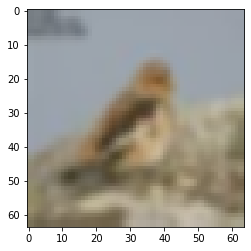

In [ ]:
print(new_x_train.shape)

idx = np.random.randint(1,x_train.shape[0])
plt.imshow(new_x_train[idx])

In [ ]:
new_x_test = np.zeros((10000,64,64,3))

for i in range(len(x_test)):
  newImage = skimage.transform.resize( x_test[i], (64,64) )
  new_x_test[i] = newImage

#for image in x_test:
#  newImage = skimage.transform.resize(image, (64, 64))
#  new_x_test = newImage

In [ ]:
#new_x_test = np.asarray(new_x_test)

(10000, 64, 64, 3)


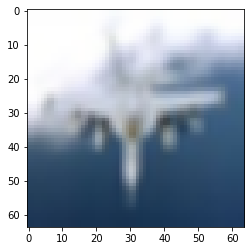

In [ ]:
print(new_x_test.shape)

idx = np.random.randint(1,x_test.shape[0])
plt.imshow(new_x_test[idx])

### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [ ]:
# Convert y_train, y_test from 2D to 1D    
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

# Convert class vectors to one hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# double check shape

print(y_train.shape)
print(y_test.shape)

# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()

for layer in vgg_model.layers:
  model.add(layer)

# print out the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

### Write your code in the cell below to freeze the weights in each layer in the new model

In [ ]:
for layer in model.layers:
  layer.trainable = False

###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [ ]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import time

start_time = time.time()
batch_size = 128


model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

training = model.fit(new_x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(new_x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/10
391/391 - 38s - loss: 1.2652 - accuracy: 0.5633 - val_loss: 1.0135 - val_accuracy: 0.6479 - 38s/epoch - 96ms/step
Epoch 2/10
391/391 - 23s - loss: 1.0203 - accuracy: 0.6465 - val_loss: 0.9350 - val_accuracy: 0.6728 - 23s/epoch - 60ms/step
Epoch 3/10
391/391 - 24s - loss: 0.9495 - accuracy: 0.6653 - val_loss: 0.9040 - val_accuracy: 0.6841 - 24s/epoch - 61ms/step
Epoch 4/10
391/391 - 24s - loss: 0.9043 - accuracy: 0.6818 - val_loss: 0.9075 - val_accuracy: 0.6865 - 24s/epoch - 61ms/step
Epoch 5/10
391/391 - 24s - loss: 0.8687 - accuracy: 0.6966 - val_loss: 0.8707 - val_accuracy: 0.6944 - 24s/epoch - 62ms/step
Epoch 6/10
391/391 - 24s - loss: 0.8385 - accuracy: 0.7053 - val_loss: 0.8760 - val_accuracy: 0.6952 - 24s/epoch - 62ms/step
Epoch 7/10
391/391 - 24s - loss: 0.8073 - accuracy: 0.7140 - val_loss: 0.8476 - val_accuracy: 0.7025 - 24s/epoch - 63ms/step
Epoch 8/10
391/391 - 25s - loss: 0.7838 - accuracy: 0.7237 - val_loss: 0.8581 - val_accuracy: 0.7030 - 25s/epoch - 63ms/step


### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

y_true = np.argmax(y_test[0:3000], axis=1)
prediction = model.predict(new_x_test[0:3000])
prediction = np.argmax(prediction, axis=1)

metrics = { 'Accuracy Score' : metrics.accuracy_score(y_true, prediction),
            'Averaged Precision Score' : metrics.precision_score(y_true, prediction, average='weighted'),
            'Averaged Recall Score' : metrics.recall_score(y_true, prediction, average='weighted'),
            'Averaged F1 Score' : metrics.f1_score(y_true, prediction, average='weighted')}
for k,v in metrics.items():
  print(f'{k} : {v}')

print(classification_report(y_true, prediction))
print( model.evaluate(new_x_test[0:3000], y_test[0:3000], verbose=0) )





94/94 [==============================] - 1s 16ms/step
Accuracy Score : 0.7043333333333334
Averaged Precision Score : 0.7143708354901369
Averaged Recall Score : 0.7043333333333334
Averaged F1 Score : 0.7068378640398397
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       299
           1       0.81      0.82      0.82       287
           2       0.66      0.62      0.64       318
           3       0.49      0.61      0.54       295
           4       0.68      0.63      0.65       299
           5       0.57      0.58      0.57       290
           6       0.70      0.79      0.74       307
           7       0.82      0.72      0.77       286
           8       0.89      0.75      0.81       316
           9       0.82      0.74      0.78       303

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.71      3000
weighted avg       0.71      0.70      0.71      3000

[0.850462019443512, 0.7

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

Photograph #2153... Actual Classification: 8 -> Predicted Classification: 8
Photograph #898... Actual Classification: 3 -> Predicted Classification: 3
Photograph #1247... Actual Classification: 3 -> Predicted Classification: 3
Photograph #1456... Actual Classification: 2 -> Predicted Classification: 2
Photograph #1613... Actual Classification: 8 -> Predicted Classification: 1


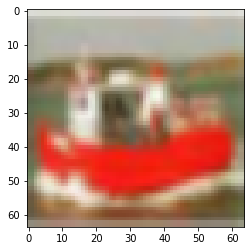

In [ ]:
for i in range(0, 5):
  idx = np.random.randint(1,prediction.shape[0])
  plt.imshow(new_x_test[idx])
  print(f'Photograph #{idx}... Actual Classification: {y_true[idx]} -> Predicted Classification: {prediction[idx]}')

